In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indonesia-tourism-destination/user.csv
/kaggle/input/indonesia-tourism-destination/tourism_rating.csv
/kaggle/input/indonesia-tourism-destination/package_tourism.csv
/kaggle/input/indonesia-tourism-destination/tourism_with_id.csv


# Intro

Before deciding trip bucket list, one needs to have an overview about the places.

Surabaya has more than enough tourism destinations, but what is the situation after covid-19 in its tourism? In October 2021, tourism sector in Indonesia was waking up after the pandemic hiatus.

This project contains the top-n tourist destination of  based on local users, rating, and places

# 1. Importing necessary Python Library

In [2]:
# Data Processing
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Data Modelling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Avoiding warning while plotting on seaborn
import warnings
warnings.filterwarnings('ignore')

# Uploading file
import os

# 2. Preparing Dataset

In [3]:
# Uploading all usable dataset
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/indonesia-tourism-destination/user.csv
/kaggle/input/indonesia-tourism-destination/tourism_rating.csv
/kaggle/input/indonesia-tourism-destination/package_tourism.csv
/kaggle/input/indonesia-tourism-destination/tourism_with_id.csv


##### Note:
* tourism_with_id.csv - contains information of 5 big cities in Indonesia, for this case, only Surabaya will be used
* user.csv - contains information of users in order to create a recommendation feature
* tourism_rating.csv - contains information of users, touristic destination, and rating to make a recommendation system based on rating

## 3. Data Understanding

## 3.1 Preparing the Data

In [4]:
# safe each dataset into variable

rating = pd.read_csv('/kaggle/input/indonesia-tourism-destination/tourism_rating.csv')
place = pd.read_csv('/kaggle/input/indonesia-tourism-destination/tourism_with_id.csv')
user = pd.read_csv('/kaggle/input/indonesia-tourism-destination/user.csv')

## 3.2 Data Features Exploration

In [5]:
# Looking into data place 

place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2


In [6]:
# Drop unused column 

place = place.drop(['Unnamed: 11','Unnamed: 12'],axis=1)
place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125


In [7]:
# Show just Surabaya
place = place[place['City']=='Surabaya']
place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
391,392,Ekowisata Mangrove Wonorejo,Hutan Wisata Mangrove Surabaya merupakan wisat...,Cagar Alam,Surabaya,0,4.3,60.0,"{'lat': -7.308648199999999, 'lng': 112.8216622}",-7.308648,112.821662
392,393,Taman Harmoni Keputih,Tempat tersebut ialah Taman Hatmoni Keputih Su...,Cagar Alam,Surabaya,0,4.4,60.0,"{'lat': -7.2952211, 'lng': 112.8035603}",-7.295221,112.803560


In [8]:
place.loc[:, ['Time_Minutes']].mean(axis = 0)

Time_Minutes    51.5
dtype: float64

In [9]:
place.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 391 to 436
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      46 non-null     int64  
 1   Place_Name    46 non-null     object 
 2   Description   46 non-null     object 
 3   Category      46 non-null     object 
 4   City          46 non-null     object 
 5   Price         46 non-null     int64  
 6   Rating        46 non-null     float64
 7   Time_Minutes  30 non-null     float64
 8   Coordinate    46 non-null     object 
 9   Lat           46 non-null     float64
 10  Long          46 non-null     float64
dtypes: float64(4), int64(2), object(5)
memory usage: 4.3+ KB


In [10]:
# looking into data rating

rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [11]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [12]:
# change data rating so that it will contain destination rating pada of Surabaya

rating = pd.merge(rating, place[['Place_Id']], how='right', on='Place_Id')
rating.head(100)

,User_Id,Place_Id,Place_Ratings
0,25,392,4
1,44,392,3
2,108,392,5
3,119,392,3
4,125,392,5
...,...,...,...
95,29,397,4
96,31,397,4
97,40,397,3
98,46,397,3


In [13]:
# seeing the shape rating for Surabaya

rating.shape

(1050, 3)

In [14]:
# look into respondents' data 

user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [15]:
# change respondents' data into Surabaya destination visitors

user = pd.merge(user, rating[['User_Id']], how='right', on='User_Id').drop_duplicates().sort_values('User_Id')
user.head()

,User_Id,Location,Age
16,1,"Semarang, Jawa Tengah",20
334,2,"Bekasi, Jawa Barat",21
641,3,"Cirebon, Jawa Barat",23
305,4,"Bekasi, Jawa Barat",21
50,5,"Lampung, Sumatera Selatan",20


In [16]:
# looking respondents' dataset who gave rating to Surabaya destinations 

user.shape

(293, 3)

# 4. Exploratory Data Analysis

In [17]:
# creating datafram that contains locations with most rating
top_10 = rating['Place_Id'].value_counts().reset_index()[0:10]

top_10 = pd.merge(top_10, place[['Place_Id','Place_Name']], how='left', left_on='index', right_on='Place_Id')
print(top_10)


# creating visualization that contains most visited destinations
# Creating visualization
# plt.figure(figsize=(8,5))
# sns.barplot('Place_Id_x', 'Place_Name', data=top_10)
# plt.title('Sum of Most Rated Destinations', pad=20)
# plt.ylabel('Sum of Rating')
# plt.xlabel('off')  # Menambahkan teks "off" sebagai label di sumbu x
# plt.show()

   index  Place_Id_x  Place_Id_y                                 Place_Name
0    437          38         437  Gereja Perawan Maria Tak Berdosa Surabaya
1    402          33         402                Food Junction Grand Pakuwon
2    430          32         430                     Atlantis Land Surabaya
3    416          31         416                           Keraton Surabaya
4    406          29         406                       Kebun Bibit Wonorejo
5    413          28         413              Museum TNI AL Loka Jala Crana
6    398          28         398                        Taman Buah Surabaya
7    427          28         427                   Patung Buddha Empat Rupa
8    405          27         405                        Surabaya North Quay
9    418          27         418      Museum Sepuluh Nopember Kota Surabaya


In [18]:
# changing the naming into English
place.Category[place.Category == 'Taman Hiburan'] = 'Amusement Park & Downtown Attractions'
place.Category[place.Category == 'Budaya'] = 'Culture'
place.Category[place.Category == 'Cagar Alam'] = 'National Park'
place.Category[place.Category == 'Taman Hiburan'] = 'Amusement Park'
place.Category[place.Category == 'Bahari'] = 'Marine Tourism'
place.Category[place.Category == 'Pusat Perbelanjaan'] = 'Shopping Center'

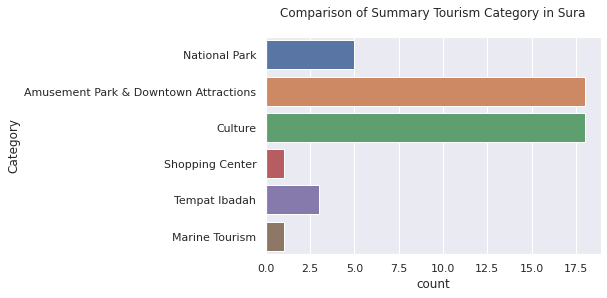

In [19]:
# creating visualization of sum category for Surabaya destinations

sns.countplot(y='Category', data=place)
plt.title('Comparison of Summary Tourism Category in Sura', pad=20)
plt.show()

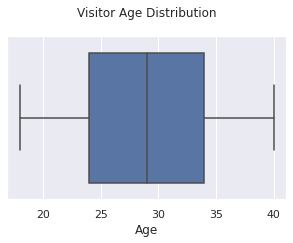

In [20]:
# visualizing visitors distribution 

plt.figure(figsize=(5,3))
sns.boxplot(user['Age']);
plt.title('Visitor Age Distribution', pad=20)
plt.show()

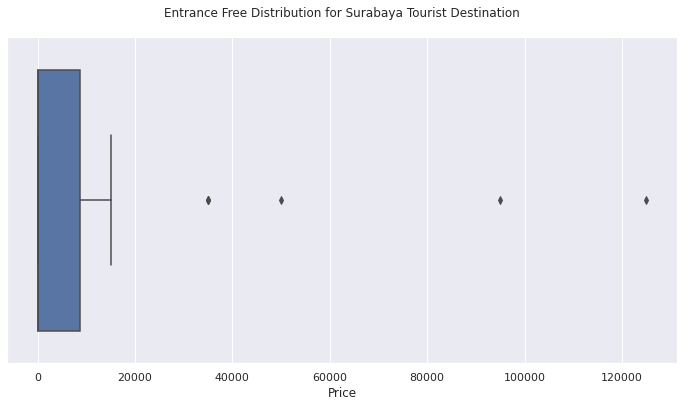

In [21]:
# visualizing entrance fee range for destinations

plt.figure(figsize=(12,6))
sns.boxplot(place['Price'])
plt.title('Entrance Free Distribution for Surabaya Tourist Destination', pad=20)
plt.show()

In [22]:
# aggregating the Price and Time_Minutes for Category destination
place.groupby("Category").agg({"Price":["mean", "sum"],
                       "Time_Minutes":["mean", "sum"]})

Price         Time_Minutes  \
                                               mean     sum         mean   
Category                                                                   
Amusement Park & Downtown Attractions  21111.111111  380000    56.363636   
Culture                                 2722.222222   49000    33.750000   
Marine Tourism                         15000.000000   15000    45.000000   
National Park                           3000.000000   15000    71.000000   
Shopping Center                            0.000000       0   120.000000   
Tempat Ibadah                           3333.333333   10000          NaN   

                                              
                                         sum  
Category                                      
Amusement Park & Downtown Attractions  620.0  
Culture                                405.0  
Marine Tourism                          45.0  
National Park                          355.0  
Shopping Center                        120.0  
Tempat Ibadah                            0.0

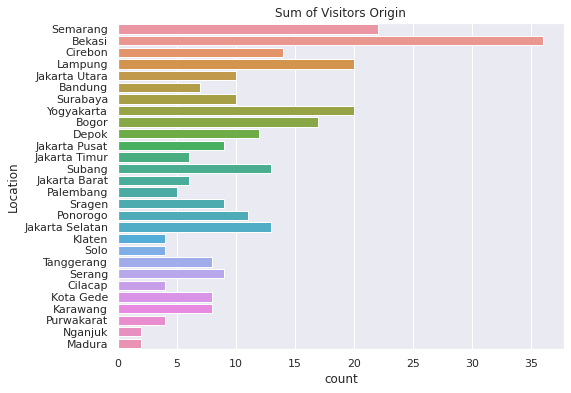

In [23]:
# filtering city origin of visitors
askot = user['Location'].apply(lambda x : x.split(',')[0])

# visualizing city origin of visitors
plt.figure(figsize=(8,6))
sns.countplot(y=askot)
plt.title('Sum of Visitors Origin')
plt.show()

# 5. Data Preparation for Modelling

## 5.1. Creating Copy for Data Rating

In [24]:
# reading dataset for encoding
 
df = rating.copy()
df.head()

,User_Id,Place_Id,Place_Ratings
0,25,392,4
1,44,392,3
2,108,392,5
3,119,392,3
4,125,392,5


## 5.2. Encoding

In [25]:
def dict_encoder(col, data=df):

  # changing column of dataframe into list with unique value
  unique_val = data[col].unique().tolist()

  # enumerating column value of dataframe 
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}

  # encoding process from numbers to column value of dataframe
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

In [26]:
# Encoding User_Id
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')

# Mapping User_Id into dataframe
df['user'] = df['User_Id'].map(user_to_user_encoded)

In [27]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id into dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

## 5.3. Looking into Data Modelling Overview

In [28]:
# getting length of user & place 
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)
 
# changing rating into float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)
 
# getting minimum and maximum rating
min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])
 
print(f'Number of User: {num_users}, Number of Place: {num_place}, Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of User: 293, Number of Place: 46, Min Rating: 1.0, Max Rating: 5.0


In [29]:
# randomizing dataset
df = df.sample(frac=1, random_state=42)
df.head(2)

,User_Id,Place_Id,Place_Ratings,user,place
352,268,407,2.0,86,15
689,75,423,1.0,281,31


# 6. Machine Learning Modelling with RecommenderNet

## 6.1. Allocating data train and test

In [30]:
# creating x variable for matching the user into one value
x = df[['user', 'place']].values
 
# crating y variable for initiatin the rating 
y = df['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# allocating data training 80% & data validation 20% 
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

## 6.2. Model Preparation

In [31]:
class RecommenderNet(tf.keras.Model):
 
  # Function initialization
  def __init__(self, num_users, num_places, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.places_embedding = layers.Embedding( # layer embeddings places
        num_places,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.places_bias = layers.Embedding(num_places, 1) # layer embedding places bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # layer embedding 2
    places_vector = self.places_embedding(inputs[:, 1]) # layer embedding 3
    places_bias = self.places_bias(inputs[:, 1]) # layer embedding 4
 
    dot_user_places = tf.tensordot(user_vector, places_vector, 2) 
 
    x = dot_user_places + user_bias + places_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [32]:
model = RecommenderNet(num_users, num_place, 50) # model initialization
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [33]:
model = RecommenderNet(num_users, num_place, 50) # model initialization
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [34]:
 class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_root_mean_squared_error')<0.25):
      print('Fulfilled expected validation matrix')
      self.model.stop_training = True

In [35]:
# begin the training
 
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks = [myCallback()]
)

Epoch 1/100
27/27 [==============================] - 2s 14ms/step - loss: 0.7388 - root_mean_squared_error: 0.3725 - val_loss: 0.6913 - val_root_mean_squared_error: 0.3478
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 0.7385 - root_mean_squared_error: 0.3739 - val_loss: 0.6919 - val_root_mean_squared_error: 0.3482
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 0.7478 - root_mean_squared_error: 0.3799 - val_loss: 0.6914 - val_root_mean_squared_error: 0.3479
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 0.7282 - root_mean_squared_error: 0.3683 - val_loss: 0.6904 - val_root_mean_squared_error: 0.3474
Epoch 5/100
27/27 [==============================] - 0s 3ms/step - loss: 0.7334 - root_mean_squared_error: 0.3736 - val_loss: 0.6905 - val_root_mean_squared_error: 0.3474
Epoch 6/100
27/27 [==============================] - 0s 3ms/step - loss: 0.7753 - root_mean_squared_error: 0.3928 - val_loss: 0.6893 - val_root_

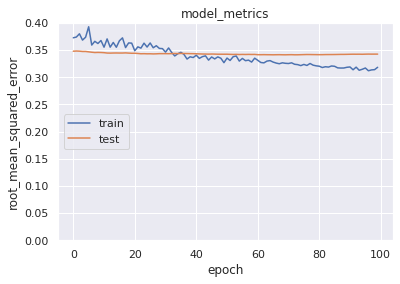

In [36]:
# showing the plot loss and validation
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.4)
plt.legend(['train', 'test'], loc='center left')
plt.show()

# 7. Prediction of 7 Recommended Destinations 

## 7.1 DataFrame Preparation to Show the Recommendations

In [37]:
# dataframe preparation
place_df = place[['Place_Id','Place_Name','Category','Rating','Price']]
place_df.columns = ['id','place_name','category','rating','price']
df = rating.copy()

## 7.2. User Example Preparation to Show Recommendations

In [38]:
# user sampling
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

In [39]:
# unvisited location data
place_not_visited = place_df[~place_df['id'].isin(place_visited_by_user.Place_Id.values)]['id'] 
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)
 
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

## 7.3. Showing the Recommendation for Users

In [40]:
# top 7 recommendations
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-7:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]
 
print('Recommendation list for: {}'.format('User ' + str(user_id)))
print('===' * 15,'\n')
print('----' * 15)
print('Places with highest rating from users')
print('----' * 15)
 
top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)
 
place_df_rows = place_df[place_df['id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.place_name, ':', row.category)

print('')
print('----' * 15)
print('Top 7 place recommendations')
print('----' * 15)
 
recommended_place = place_df[place_df['id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.place_name, '\n    ', row.category, ',', 'Entrance Fee', row.price, ',', 'Rating', row.rating,'\n')

print('==='*15)

Recommendation list for: User 160

------------------------------------------------------------
Places with highest rating from users
------------------------------------------------------------
Taman Buah Surabaya : Amusement Park & Downtown Attractions
Rumah Batik : Culture
Atlantis Land Surabaya : Amusement Park & Downtown Attractions
Taman Mundu : Amusement Park & Downtown Attractions

------------------------------------------------------------
Top 7 place recommendations
------------------------------------------------------------
1 . Taman Prestasi 
     Amusement Park & Downtown Attractions , Entrance Fee 0 , Rating 4.6 

2 . Monumen Kapal Selam 
     Culture , Entrance Fee 15000 , Rating 4.4 

3 . Taman Pelangi 
     Amusement Park & Downtown Attractions , Entrance Fee 0 , Rating 4.5 

4 . Taman Keputran 
     Amusement Park & Downtown Attractions , Entrance Fee 0 , Rating 4.3 

5 . Taman Ekspresi Dan Perpustakaan 
     Amusement Park & Downtown Attractions , Entrance Fee 0 , 

In [41]:
model.summary()

Model: "recommender_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      multiple                  14650     
_________________________________________________________________
embedding_5 (Embedding)      multiple                  293       
_________________________________________________________________
embedding_6 (Embedding)      multiple                  2300      
_________________________________________________________________
embedding_7 (Embedding)      multiple                  46        
Total params: 17,289
Trainable params: 17,289
Non-trainable params: 0
_________________________________________________________________


## *Reference*


  * https://github.com/AgungP88/getloc-apps/tree/machine-learning
  * https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system
  * https://www.kaggle.com/aprabowo/indonesia-tourism-destination
  * https://www.dicoding.com/academies/319
  * https://www.kaggle.com/code/rafkaip/sistem-rekomendasi-destinasi-wisata-kota-bandung